In [1]:
import diffrax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np

from dynax import (
    AbstractSystem,
    fit_least_squares,
    Flow,
    non_negative_field,
    pretty,
)


np.random.seed(42)

Setting jax_enable_x64 to True.


# Example: estimating the parameters of a linearized system

In this example, we estimate the values and covariances of the parameters $m$, $r$, $r_2$ and $k$ of a forced, nonlinear mass-spring-damper system
$$
m ẍ +  r ẋ + r_2 ẋ |ẋ| + k x = u.
$$
We assume the measurement of the position $x$ in millineter, so the measurement equation is
$y = 1000x$.
Further, we have some prior knowledge of the system in terms of value bounds for the unknown parameters:
$$
\begin{align}
m &\in \mathbb R \\
r &\in [0, \infty) \\
r_2 &\in [0.01, 1] \\
k &\in [0.001, 2]
\end{align}
$$


In Dynax, the `AbstractSystem` class models ODE with measurement equations. Bounds for trainable parameters arespecified with `boxed_field` or `non_negative_field`. Fixed parameters can be marked with `static_field`. 

In [2]:
class NonlinearDrag(AbstractSystem):
    # Declare parameters as dataclass fields.
    alpha: float = non_negative_field()
    beta: float = non_negative_field()
    delta: float = non_negative_field()
    gamma: float = non_negative_field()

    # Set the number of states (order of system) and inputs.
    initial_state = jnp.zeros(2)
    n_inputs = "scalar"

    # Define the vector field of the dynamical system
    def vector_field(self, x, u, t):
        x, y = x
        # u = u.squeeze() if u is None else 0.
        return jnp.array(
            [
                self.alpha * x - self.beta * x * y,
                -self.delta * y + self.gamma * x * y + u,
            ]
        )

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


We combine an instance of the dynamical system with an ODE solver via the `Flow` class. Flows represent forward models that solve an ODE.

In [3]:
true_model = Flow(system=NonlinearDrag(alpha=1.5, beta=1.0, delta=3.0, gamma=1.0))
print("true forward model:", true_model)

true forward model: Flow(
  system=NonlinearDrag(
    initial_state(static)=f64[2],
    n_inputs(static)='scalar',
    alpha(boxed: (0.0, inf))=1.5,
    beta(boxed: (0.0, inf))=1.0,
    delta(boxed: (0.0, inf))=3.0,
    gamma(boxed: (0.0, inf))=1.0
  ),
  solver(static)=Dopri5(scan_kind=None),
  stepsize_controller(static)=ConstantStepSize()
)


Let's create some data with the forward model.

Let's create a new dynamical system object with some initial parameters that we want to fit.

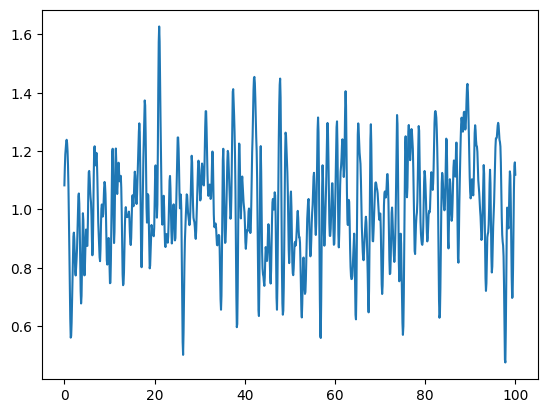

In [4]:
# time
t = np.linspace(0, 100, 1000)
# forcing signal
u = np.convolve(np.random.normal(size=t.shape), np.hanning(10), "same") / 10 + 1
plt.plot(t, u)

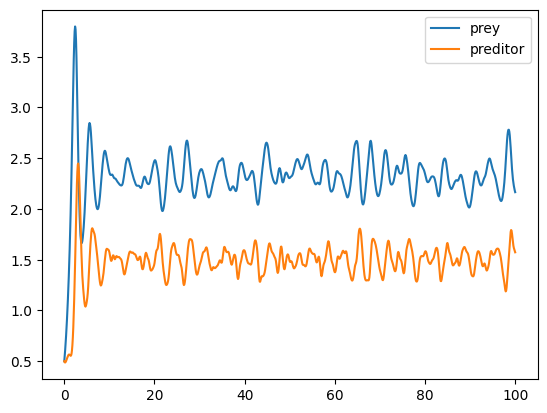

In [5]:
# zero initial state
x0 = jnp.array([0.5, 0.5])
# true_model returns a tuple(states, outputs)
x, _ = true_model(t, u=u, initial_state=x0, max_steps=int(1e6))

plt.plot(t, x)
plt.legend(["prey", "preditor"])

In [7]:
init_model = Flow(
    system=NonlinearDrag(alpha=1.0, beta=1.0, delta=1.0, gamma=1.0),
    solver=diffrax.Tsit5(),
    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)

Combine the initial ODE system with an ODE solver and fit it using nonlinear Least-Squares.

In [9]:
res = fit_least_squares(model=init_model, t=t, y=x, u=u, verbose=2)
pred_model = res.result
print("fitted system:", pretty(pred_model.system))
print("Normalized mean squared error:", res.nrmse)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         4.3730e+01                                    1.25e+01    
       1              2         4.0713e+01      3.02e+00       3.26e-01       1.14e-02    
       2              3         4.0707e+01      6.71e-03       1.37e-04       2.87e-02    
       3              9         4.0705e+01      1.35e-03       2.50e-04       3.19e-02    
       4             18         4.0705e+01      0.00e+00       0.00e+00       3.19e-02    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 4.3730e+01, final cost 4.0705e+01, first-order optimality 3.19e-02.
fitted system: NonlinearDrag(
  initial_state(static)=Array([0., 0.], dtype=float64),
  n_inputs(static)='scalar',
  alpha(boxed: (0.0, inf))=Array(1., dtype=float64),
  beta(boxed: (0.0, inf))=Array(1., dtype=float64),
  delta(boxed: (0.0, inf))=Array(0.6744583, dtype=float64),
  gamma(boxed: (0.0, inf)

Compare true and estimated output.

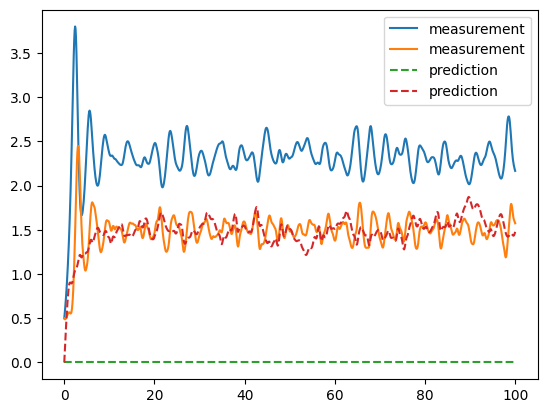

In [10]:
x_pred, _ = pred_model(t, u, initial_state=x0)

plt.plot(t, x, label="measurement")
plt.plot(t, res.y_pred, "--", label="prediction")

plt.legend()
plt.show()

In [11]:
from dynax import fit_csd_matching


result = fit_csd_matching(init_model.system, u, x, verbose=2, nperseg=128)
init_system = result.result

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.9809e-01                                    5.58e-01    
       1              2         4.3129e-01      1.67e-01       1.96e+00       2.85e-02    
       2              3         4.2994e-01      1.35e-03       8.53e-01       1.44e-02    
       3              5         4.2809e-01      1.85e-03       2.44e-01       1.99e-03    
       4              8         4.2805e-01      4.38e-05       3.06e-02       8.97e-04    
       5             10         4.2804e-01      9.75e-06       1.53e-02       3.82e-04    
       6             12         4.2804e-01      1.96e-06       7.64e-03       1.32e-04    
       7             14         4.2803e-01      2.70e-07       3.82e-03       9.02e-06    
       8             17         4.2803e-01      6.48e-10       4.77e-04       1.52e-05    
`ftol` termination condition is satisfied.
Function evaluations 17, initial cost 5.9809e-0

In [13]:
init_model = Flow(
    system=init_system,
    solver=diffrax.Dopri5(),
    stepsize_controller=diffrax.PIDController(rtol=1e-3, atol=1e-6),
)
res = fit_least_squares(model=init_model, t=t, y=x, u=u, verbose=2)
pred_model = res.result
print("fitted system:", pretty(pred_model.system))
print("Normalized mean squared error:", res.nrmse)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         5.5484e+01                                    1.16e+01    
       1              2         4.0736e+01      1.47e+01       7.17e-01       6.69e-01    
       2              7         4.0731e+01      4.97e-03       9.20e-04       5.98e-01    
       3              8         4.0708e+01      2.35e-02       1.83e-03       8.15e-01    
       4             14         4.0692e+01      1.60e-02       1.29e-06       1.26e+00    
       5             19         4.0692e+01      0.00e+00       0.00e+00       1.26e+00    
`xtol` termination condition is satisfied.
Function evaluations 19, initial cost 5.5484e+01, final cost 4.0692e+01, first-order optimality 1.26e+00.
fitted system: NonlinearDrag(
  initial_state(static)=Array([0., 0.], dtype=float64),
  n_inputs(static)='scalar',
  alpha(boxed: (0.0, inf))=Array(1., dtype=float64),
  beta(boxed: (0.0, inf))=Array(1., dtype=floa